In [23]:
import os 
import numpy as np
from skimage import io, color, measure, segmentation, morphology
from scipy import ndimage as ndi
import cv2
import czifile
import os 
import numpy as np
import matplotlib.pyplot as plt


def dilate_mask(mask, size):
    selem = morphology.disk(size)
    dilated_mask = morphology.dilation(mask, selem)
    return dilated_mask

def process_mask(mask_path, image):

    # print(image.shape)

    # Load the label image
    msk = io.imread(mask_path)
    print("start after read shape", msk.shape)
    # Ensure the image is 2D if it has a color channel
    image = image[:, :msk.shape[0], :msk.shape[1],: ]
    if msk.ndim == 3:
        msk = color.rgb2gray(msk)

    # Apply a binary threshold to the image
    binary_img = msk > 0

    # Compute the distance transform
    distance = ndi.distance_transform_edt(binary_img)

    # Find local maxima in the distance transform
    local_maxi = morphology.local_maxima(distance)

    # Label the local maxima as markers for the watershed
    markers = measure.label(local_maxi)

    # Apply watershed segmentation
    label2 = segmentation.watershed(-distance, markers, mask=binary_img)
    labels = morphology.area_opening(label2, 130)

    # Get the number of unique objects after watershed
    num_objects = labels.max()
    print("Number of objects:", num_objects)

    # Process each object to create inner part masks
    props = measure.regionprops(labels)
    all_masks = np.zeros((len(props), msk.shape[0], msk.shape[1]), dtype=np.uint8)

    for nid, prop in enumerate(props):
        output_image = np.zeros_like(msk, dtype=np.uint8)
        region_coords = prop.coords
        output_image[region_coords[:, 0], region_coords[:, 1]] = 1

        # Define the erosion kernel size
        kernel_size = 3
        kernel = np.ones((kernel_size, kernel_size), np.uint8)

        # Perform erosion
        eroded_image = cv2.erode(output_image, kernel, iterations=1)
        dapi_dilated = dilate_mask(output_image, 5)

        # Create a mask to exclude the inner part
        inner_part_mask = dapi_dilated - eroded_image

        # Store the inner_part_mask in the array
        all_masks[nid] = inner_part_mask

    return all_masks, image


def calculate_bounding_boxes(objects_array, padding=50):
    bounding_boxes = []
    height, width = objects_array.shape[1], objects_array.shape[2]  # Assuming shape [num_objects, H, W]
    
    for i in range(objects_array.shape[0]):
        object_slice = objects_array[i, :, :]
        
        # Find non-zero points (where object exists)
        coords = np.column_stack(np.where(object_slice > 0))
        
        if coords.size == 0:
            continue
        
        # Determine bounding box coordinates with padding
        x_min, y_min = coords.min(axis=0) - padding
        x_max, y_max = coords.max(axis=0) + padding
        
        # Ensure the coordinates do not go out of image boundaries
        x_min = max(x_min, 0)
        y_min = max(y_min, 0)
        x_max = min(x_max, width)
        y_max = min(y_max, height)
        
        # Append coordinates as (x_min, y_min, width, height)
        bounding_boxes.append([y_min, x_min, y_max - y_min, x_max - x_min])
        
    return bounding_boxes

def extract_patches(image, mask, bounding_boxes): 
    image_patches = []
    mask_patches = []
    
    for i, box in enumerate(bounding_boxes):
        # print("box:", box)
        y_min, x_min, width, height = box
        
        # Check if width or height are negative
        if width < 0 or height < 0:
            print(f"Skipping box with invalid dimensions: {box}")
            continue
        
        # Extract patches from both image and mask using the same bounding box
        # image=image.T
        image_patch = image[:, x_min:x_min + height, y_min:y_min + width]
        mask_patch = mask[i, x_min:x_min + height, y_min:y_min + width]

        print("image_patch.shape:", image_patch.shape)
        print("mask_patch.shape:", mask_patch.shape)        

        image_patches.append(image_patch)
        mask_patches.append(mask_patch)
    
    return image_patches, mask_patches

def save_patches(image, mask_channels, bounding_boxes, save_directory, file_name):
    os.makedirs(os.path.join(save_directory, 'image'), exist_ok=True)
    os.makedirs(os.path.join(save_directory, 'mask'), exist_ok=True)

    for i, box in enumerate(bounding_boxes):
        y_min, x_min, width, height = box
        if width < 0 or height < 0:
            print(f"Skipping box with invalid dimensions: {box}")
            continue
        
        # Extract patches from both image and mask using the same bounding box
        image_patch = image[:, x_min:x_min + height, y_min:y_min + width, 0]
        mask_patch = mask_channels[i, x_min:x_min + height, y_min:y_min + width]

        print("image_patch.shape:", image_patch.shape)
        print("mask_patch.shape:", mask_patch.shape)        
        # Saving the patches
        image_patch_path = os.path.join(save_directory, 'image', f'{file_name}_image_patch_{i}.npy')
        mask_patch_path = os.path.join(save_directory, 'mask', f'{file_name}_mask_patch_{i}.npy')
        np.save(image_patch_path, image_patch)
        np.save(mask_patch_path, mask_patch)

# Example usage
image_path = '/home/sshabani/projects/Grad_CAMO/data/non_lymphos/A1818_P0025_4MGRTumor_2.czi'
mask_path  = '/home/sshabani/projects/Grad_CAMO/data/non_lymphos/A1818_P0025_4MGRTumor_2_mask.png'

save_directory = '/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/'

# Extract file name without extension to use in saved file names
file_name = os.path.splitext(os.path.basename(image_path))[0]

image = czifile.imread(image_path)
mask_channels, image= process_mask(mask_path, image)
bounding_boxes = calculate_bounding_boxes(mask_channels, padding=10)

save_patches(image, mask_channels, bounding_boxes, save_directory, file_name)

start after read shape (1024, 1280)
Number of objects: 152
image_patch.shape: (6, 44, 41)
mask_patch.shape: (44, 41)
image_patch.shape: (6, 45, 37)
mask_patch.shape: (45, 37)
image_patch.shape: (6, 50, 45)
mask_patch.shape: (50, 45)
image_patch.shape: (6, 54, 35)
mask_patch.shape: (54, 35)
image_patch.shape: (6, 32, 37)
mask_patch.shape: (32, 37)
image_patch.shape: (6, 46, 38)
mask_patch.shape: (46, 38)
image_patch.shape: (6, 50, 59)
mask_patch.shape: (50, 59)
image_patch.shape: (6, 61, 63)
mask_patch.shape: (61, 63)
image_patch.shape: (6, 57, 54)
mask_patch.shape: (57, 54)
image_patch.shape: (6, 45, 52)
mask_patch.shape: (45, 52)
image_patch.shape: (6, 44, 47)
mask_patch.shape: (44, 47)
image_patch.shape: (6, 45, 33)
mask_patch.shape: (45, 33)
image_patch.shape: (6, 53, 48)
mask_patch.shape: (53, 48)
image_patch.shape: (6, 42, 46)
mask_patch.shape: (42, 46)
image_patch.shape: (6, 44, 55)
mask_patch.shape: (44, 55)
image_patch.shape: (6, 45, 56)
mask_patch.shape: (45, 56)
image_patch.s

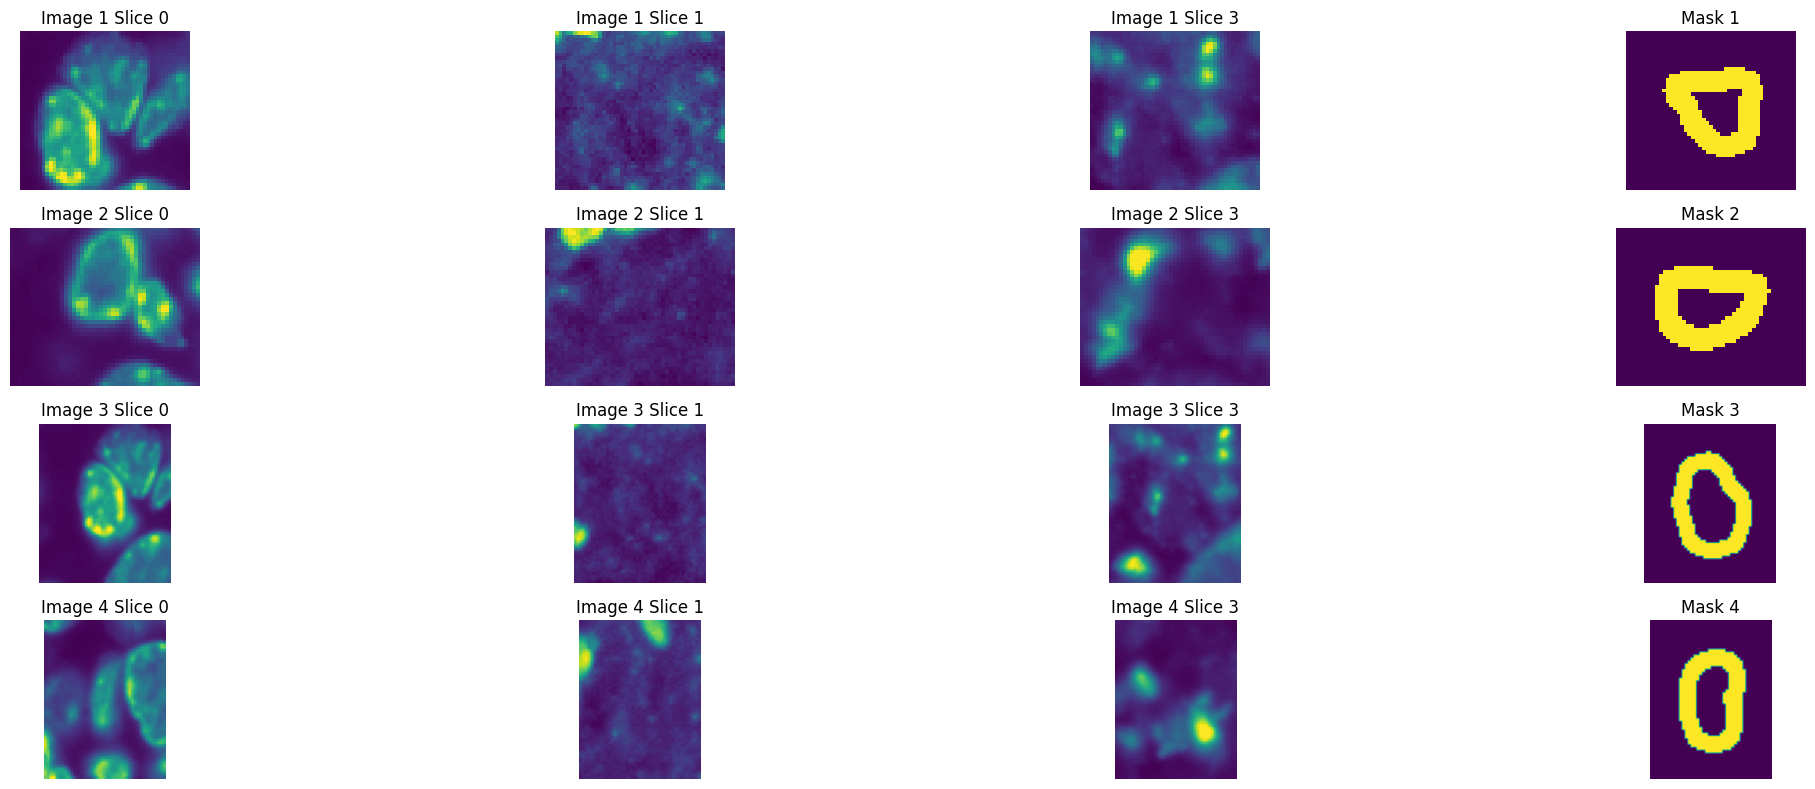

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Paths for images and masks
image_paths = [
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/image/A1818_P0025_4MGRTumor_2_image_patch_10.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/image/A1818_P0025_4MGRTumor_2_image_patch_25.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/image/A1818_P0025_4MGRTumor_2_image_patch_20.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/image/A1818_P0025_4MGRTumor_2_image_patch_18.npy"
]

mask_paths = [
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_10.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_25.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_20.npy",
    "/home/sshabani/projects/Grad_CAMO/data/preprocessed/non_lymph/mask/A1818_P0025_4MGRTumor_2_mask_patch_18.npy"
]

# Loading images and masks
images = [np.load(path) for path in image_paths]
masks = [np.load(path) for path in mask_paths]

# Plotting configuration
plt.figure(figsize=(24, 8))  # Adjusted figure size to accommodate 12 subplots

# Display three slices from each image and the corresponding mask
for idx, img in enumerate(images):
    # Plotting the first slice
    plt.subplot(4, 4, 1 + idx * 4)
    plt.imshow(img[0, :, :])
    plt.title(f"Image {idx + 1} Slice 0")
    plt.axis('off')

    # Plotting the second slice
    plt.subplot(4, 4, 2 + idx * 4)
    plt.imshow(img[1, :, :])
    plt.title(f"Image {idx + 1} Slice 1")
    plt.axis('off')

    # Plotting the third slice
    plt.subplot(4, 4, 3 + idx * 4)
    plt.imshow(img[3, :, :])
    plt.title(f"Image {idx + 1} Slice 3")
    plt.axis('off')

    # Plotting the mask
    plt.subplot(4, 4, 4 + idx * 4)
    plt.imshow(masks[idx])
    plt.title(f"Mask {idx + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


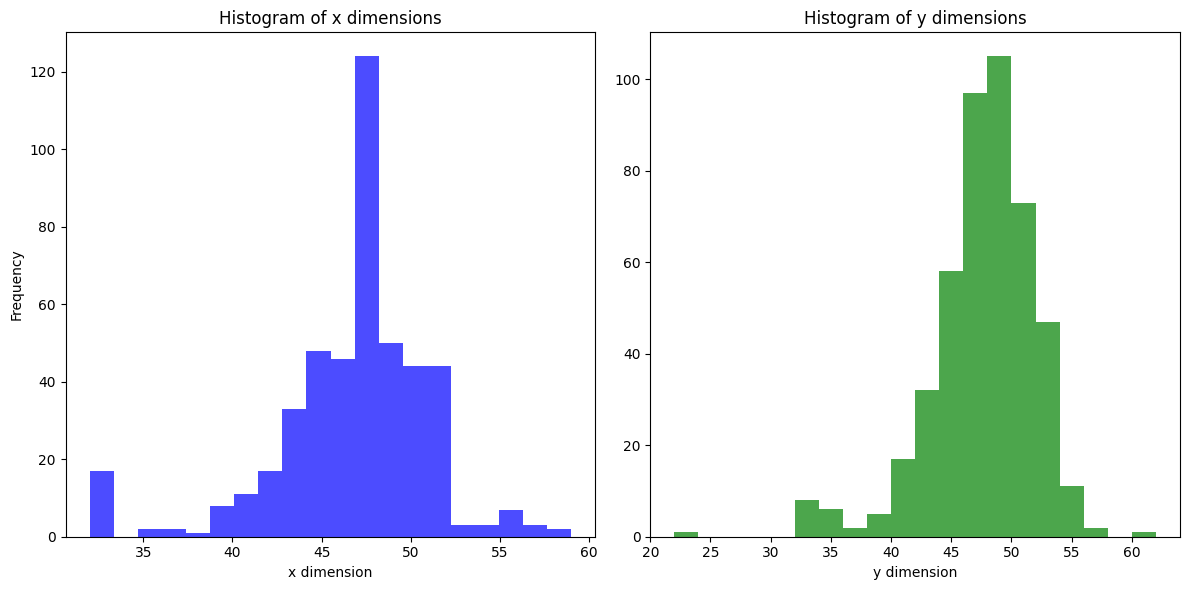

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_dimensions_distribution(directory):
    x_dims = []
    y_dims = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".npy"):  # Check for numpy files
            file_path = os.path.join(directory, filename)
            data = np.load(file_path)
            if data.ndim == 2:  # Assuming 2D numpy arrays; adjust if different
                x_dims.append(data.shape[0])
                y_dims.append(data.shape[1])
            elif data.ndim > 2:  # If multi-dimensional, consider the first two dimensions
                x_dims.append(data.shape[1])
                y_dims.append(data.shape[2])

    # Plotting the histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(x_dims, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of x dimensions')
    plt.xlabel('x dimension')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(y_dims, bins=20, color='green', alpha=0.7)
    plt.title('Histogram of y dimensions')
    plt.xlabel('y dimension')

    plt.tight_layout()
    plt.show()

# Usage
directory = '/home/sshabani/projects/Grad_CAMO/data/preprocessed/lymph/mask'  # Path to the directory containing numpy files
plot_dimensions_distribution(directory)


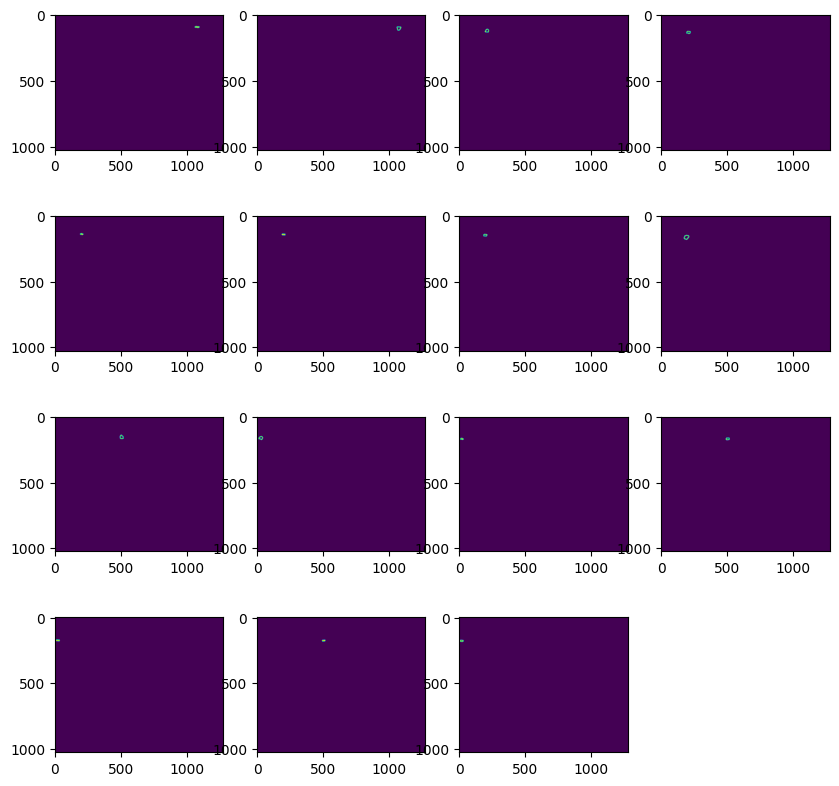

In [11]:
# mask_channels[1].shape
plt.figure(figsize=(10,10))
for i in range(1,16):
    plt.subplot(4,4,i)
    plt.imshow(mask_channels[i])

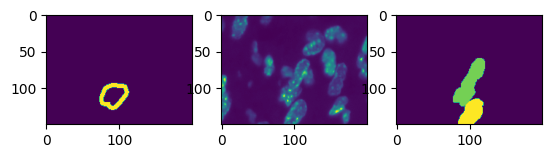

In [19]:
# Load the label image
msk = io.imread(mask_path)



plt.subplot(1,3,1)
plt.imshow(mask_channels[8][50:200,100:300])

plt.subplot(1,3,2)
plt.imshow(image[0,50:200,100:300,0])

plt.subplot(1,3,3)
plt.imshow(msk[50:200,100:300])

